<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/Binario_CEL_resnet18_BalanceoImblearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Binario

## Librerías

In [1]:
!pip install fastai==2.6.3 -Uq

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

In [1]:
!pip install wwf -q

     |████████████████████████████████| 431 kB 8.5 MB/s 


In [2]:
from fastai.vision.all import *

import timm

from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip


2022-06-19 17:50:43 URL:https://uc275290938ecfd768afc86b66a7.dl.dropboxusercontent.com/cd/0/inline2/Bng7BEDSqY8t82nwTxz3mwdUz8vHzJv5a_wTRgrVMMTsUUwQy733TmgQCAY--r68ftRzPdJEnGPD4inNfqqoJEAYW8ymU4v-grWnJ_nPsN6SPG-nn7qufpfHoxd1HVp2zn3VCj90tSz_RZbMOpcZa_TweZiQXJPPvCAm_XjL3XVoXYZmLDSp7XK2FmNe3OVG8La-R-RhoxQ_ucYpJPP0kioZlAPLoE2Xd3Yqal4Ovj1LLfuycodbRmHFrekqWIdRUpqJ6dIMoXRweU6iLRwdnBClfKNu5UWrnIre9O95utRtlSzpnpbyxC-sCEp23HMDaaWOnM_MQr2uCjJcr3uDBfSj4d7JKmEHvenglhzu-fP5j7I8_mJHr9teIzH5fQqyUz5hDRa2kGi5ayRYGII8z6yHk6ErvWMCsbf3Ldajy05SEg/file [138777773/138777773] -> "train.zip" [1]
2022-06-19 17:50:46 URL:https://uce951bf8e52417f9132db3a4873.dl.dropboxusercontent.com/cd/0/inline2/BngGugRx_G9C7GIey-K8xLDYsnYGiP33bQqMBHIE-H8it53OD0aCFRBOThg-vr-bVZmmUjyfCEz2rk5fSu8ePvYiHJ3e8iAGuZ2Xsnx28S1CR0qjWbAJ3fXMEtFu1Y5XQ0t3j93ID0UaOu68L3UXfoIb0m9nokS56KR-uhAeth32cxz_a1Pu_XNMPHqOR-Fu0HR1bnbahfIn5x-ebF--0TUb9OQUMCxUzmpO4Me6jUUA4r3XYrIv-DnUjm32TtSggJTGJiCMab8LvIg_ptteJDIKpQand-S5UxJrQJ1_T3KguCdBTVvC_6XvwyVj13Kj9GV

In [4]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [5]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [6]:
crearEstructura('dataset', ['normal', 'enfermedad'])

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [7]:
path = Path('dataset/')

In [8]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [9]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [10]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [11]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Una vez creada la estructura mencionada antes movemos las imágenes a la carpeta que corresponda. Ahora en la función moverImg() debemos copiar las imagenes en vez de moverlas ya que algunas se van a duplicar. También debemos dar un nombre random cada vez para conseguir que se dupliquen y no se sobreescriban cada vez.

In [12]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

## Balanceo

### Balanceando el conjunto de entrenamiento con la librería Imblearn:

Duplicaremos de forma aleatoria las intancias del dataframe de train, después moveremos la imágenes en función del dataset.


In [13]:
y = df_train.Disease_Risk
X = df_train.drop('Disease_Risk', axis=1)

In [14]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = RandomOverSampler(sampling_strategy=0.50) #Aumentaremos hasta la mitad de lo que es la clase mayoritaria (759)
under = RandomUnderSampler(sampling_strategy=1) #clase mayoriataria
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [15]:
from collections import Counter

# evaluate pipeline
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 759, 1: 759})


In [16]:
X['Disease_Risk'] = y

In [17]:
df_train = X

In [18]:
len(df_train[df_train['Disease_Risk']==1].ID.unique())

759

In [19]:
len(df_train[df_train['Disease_Risk']==0].ID.unique())

401

**Ahora que ya tenemos la estructura deseada empezamos a construir el modelo:**

In [20]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

In [21]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

640

In [22]:
len(Path('dataset/train/normal').ls()) #401

759

## Cargando el dataset

In [23]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [24]:
dls = db.dataloaders(path,bs=128)

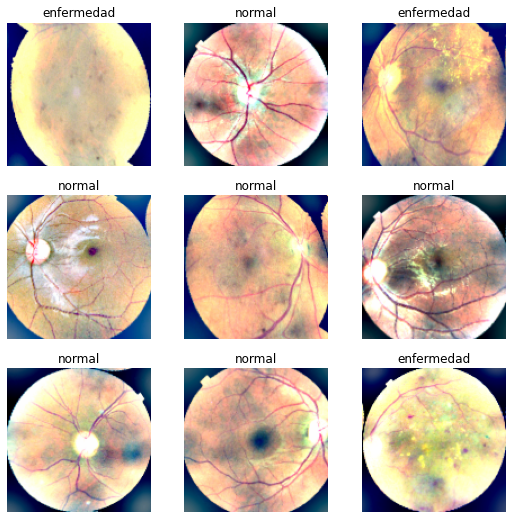

In [25]:
dls.show_batch()

In [26]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()  
]

In [28]:
metrics=[ accuracy, Precision(), Recall(), F1Score(), error_rate ]
learn = cnn_learner(dls, resnet18, metrics=metrics, cbs=callbacks).to_fp16() #timm_learner

SuggestedLRs(minimum=0.010000000149011612, steep=0.0014454397605732083, valley=0.001737800776027143, slide=0.009120108559727669)

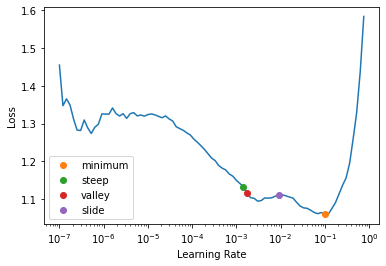

In [29]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.272063,0.942818,0.484375,0.233696,0.641791,0.342629,0.515625,00:11


Better model found at epoch 0 with valid_loss value: 0.9428176879882812.


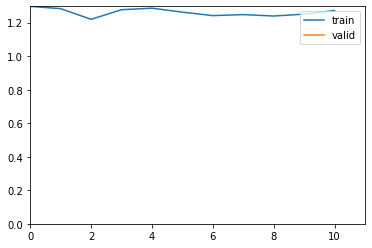

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.315242,0.819411,0.562500,0.223485,0.440299,0.296482,0.437500,00:11
1,1.289332,0.865827,0.535937,0.217993,0.470149,0.297872,0.464063,00:09
2,1.282926,0.882861,0.534375,0.209220,0.440299,0.283654,0.465625,00:12
3,1.258133,0.883390,0.528125,0.225490,0.514925,0.313636,0.471875,00:09
4,1.255082,0.851124,0.539062,0.234323,0.529851,0.324943,0.460938,00:09
5,1.258687,0.848369,0.528125,0.227273,0.522388,0.316742,0.471875,00:10
6,1.259514,0.822199,0.540625,0.226027,0.492537,0.309859,0.459375,00:09
7,1.259651,0.834590,0.560938,0.255814,0.574627,0.354023,0.439063,00:09
8,1.263772,0.788901,0.571875,0.256944,0.552239,0.350711,0.428125,00:16
9,1.233846,0.803482,0.585938,0.280936,0.626866,0.387991,0.414062,00:09


Better model found at epoch 0 with valid_loss value: 0.8194106817245483.


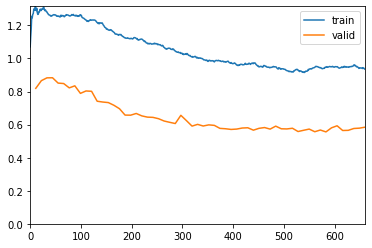

Better model found at epoch 8 with valid_loss value: 0.7889005541801453.
Better model found at epoch 11 with valid_loss value: 0.7414382100105286.
Better model found at epoch 12 with valid_loss value: 0.7365258932113647.
Better model found at epoch 13 with valid_loss value: 0.7332347631454468.
Better model found at epoch 14 with valid_loss value: 0.7169581651687622.
Better model found at epoch 15 with valid_loss value: 0.6961034536361694.
Better model found at epoch 16 with valid_loss value: 0.6575807332992554.
Better model found at epoch 17 with valid_loss value: 0.657054603099823.
Better model found at epoch 19 with valid_loss value: 0.6527721285820007.
Better model found at epoch 20 with valid_loss value: 0.6452680826187134.
Better model found at epoch 21 with valid_loss value: 0.6437580585479736.
Better model found at epoch 22 with valid_loss value: 0.6357436776161194.
Better model found at epoch 23 with valid_loss value: 0.6216757297515869.
Better model found at epoch 24 with vali

In [30]:
%%time
learn.fine_tune(60,base_lr=1e-5)

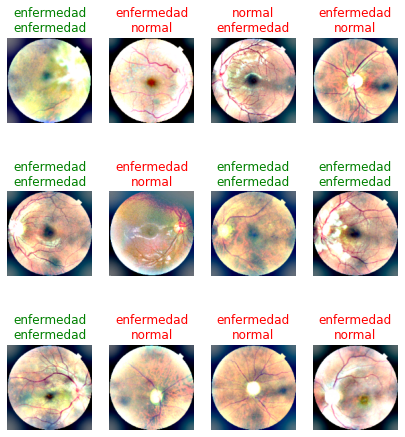

In [31]:
learn.show_results(max_n=12, figsize=(7,8))

Exportamos el modelo

In [32]:
learn.to_fp32()
learn.export('Binario_CEL_resnet18_BalanceoImblearn.pkl')

## Evaluando el modelo

In [33]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [34]:
learn.dls = dlsTest

El valor de la función de perdida es de 0.29 y su accuracy es del 86%.

In [35]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7015625238418579.


(#6) [0.5749478936195374,0.7015625238418579,0.379746835443038,0.6716417910447762,0.4851752021563342,0.2984375059604645]

## Interpretación del modelo

In [36]:
learn.dls=dls

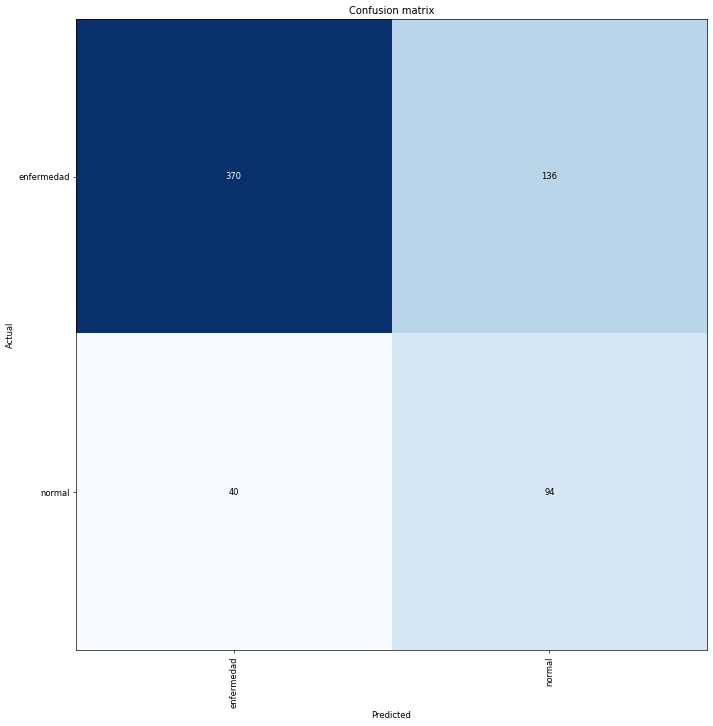

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4),dpi=100)